# Ex 8

In [1]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
# from util_functions import (
#     gaussian_1D_kernel,
# )

from math import sqrt
from skimage import data
from skimage.feature import blob_dog
from skimage.color import rgb2gray

In [2]:
cv2.__version__

'4.6.0'

## Building a BLOB detector that uses Difference-of-Gaussians

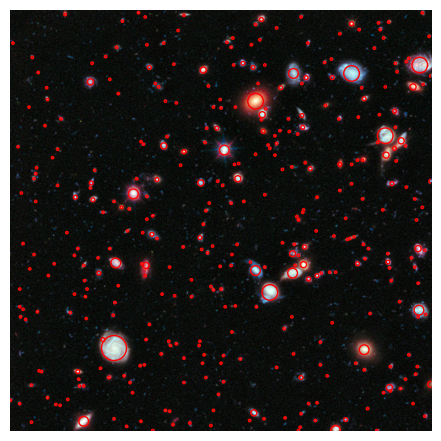

In [3]:
# Example taken from
# https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html

image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)  # Compute radii in the 3rd column

plt.figure()
plt.imshow(image, cmap="gray")
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="red", linewidth=1, fill=False)
    plt.gca().add_patch(c)
plt.tight_layout()
plt.axis("off")
plt.show()

(660, 1066)


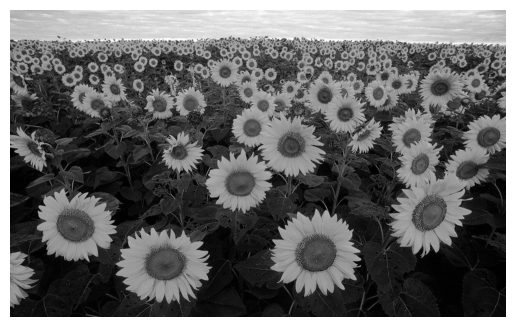

In [4]:
im = cv2.imread("media/sunflowers.jpg").astype(float).mean(2) / 255

plt.imshow(im, cmap="gray")
plt.axis("off")
print(im.shape)

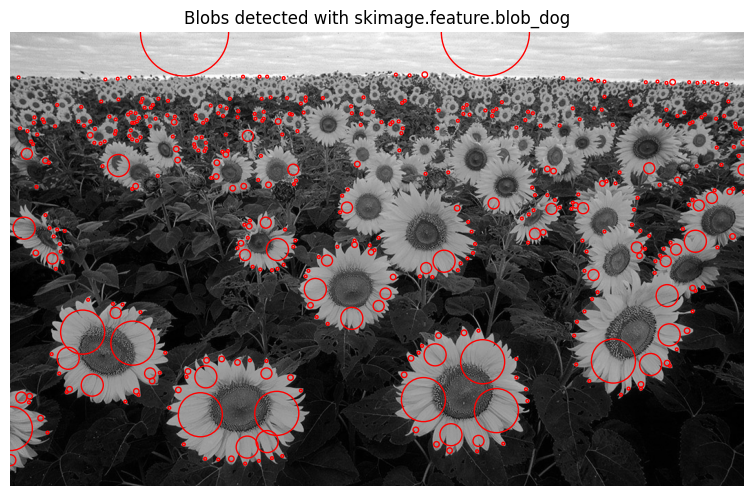

In [34]:
# Using skimage.feature.blob_dog to detect blobs
blobs_dog = blob_dog(
    im, min_sigma=2, max_sigma=128, sigma_ratio=2, threshold=0.1
)

plt.figure()
plt.imshow(im, cmap="gray")
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="red", linewidth=1, fill=False)
    plt.gca().add_patch(c)
plt.tight_layout()
plt.axis("off")
plt.title("Blobs detected with skimage.feature.blob_dog")
plt.show()

In [6]:
def gaussian_1D_kernel(sigma):
    """
    Returns the 1D Gaussian kernel.

    Args:
        sigma : width of Gaussian kernel

    Returns:
        g : 1D Gaussian kernel
        gd : 1D Gaussian kernel derivative
    """
    if sigma == 0:
        return [1], [0]
    rule = 5
    x = np.arange(-rule * sigma, rule * sigma + 1)
    g = np.exp(-(x**2) / (2 * sigma**2))
    g = g / g.sum()  # normalize
    gd = -x / (sigma**2) * g
    return g, gd

In [7]:
# Ex 8.1
def scale_spaced(im, sigma, n):
    """
    Naive implementation of the scale space pyramid with no downsampling.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales

    Returns:
        im_scales : list containing the scale space pyramid of the input image
        scales : list containing the scales used in the pyramid
    """
    scales = [sigma * 2**i for i in range(n)]  # ratio = 2
    im_scales = []
    im_scale = im
    for scale in scales:
        # Apply Gaussian filter on the previously scaled image
        g, _ = gaussian_1D_kernel(scale)
        im_scale = cv2.sepFilter2D(
            src=im_scale, ddepth=-1, kernelX=g, kernelY=g
        )
        im_scales.append(im_scale)
    return im_scales, scales

im shape: (660, 1066)
scales: [2, 4, 8, 16, 32, 64, 128]
[array([[0.7087512 , 0.70855557, 0.70792362, ..., 0.72345681, 0.72209042,
        0.72155834],
       [0.71068443, 0.71051924, 0.70997868, ..., 0.72109907, 0.71987601,
        0.7194124 ],
       [0.71524327, 0.71517999, 0.71493566, ..., 0.71542251, 0.71458837,
        0.71430716],
       ...,
       [0.05211018, 0.05126105, 0.04871635, ..., 0.03580504, 0.03615633,
        0.03629273],
       [0.05158151, 0.05060896, 0.04771883, ..., 0.03619607, 0.03660521,
        0.0367729 ],
       [0.05136104, 0.05033828, 0.04731158, ..., 0.03634964, 0.03677805,
        0.03695683]]), array([[0.7146587 , 0.71451645, 0.71409154, ..., 0.7190999 , 0.71870325,
        0.71856918],
       [0.71470707, 0.71456728, 0.71414948, ..., 0.71934393, 0.71894789,
        0.71881402],
       [0.71481036, 0.71467775, 0.71428077, ..., 0.72012387, 0.7197292 ,
        0.71959577],
       ...,
       [0.050321  , 0.0503631 , 0.05050141, ..., 0.03559773, 0.0355403

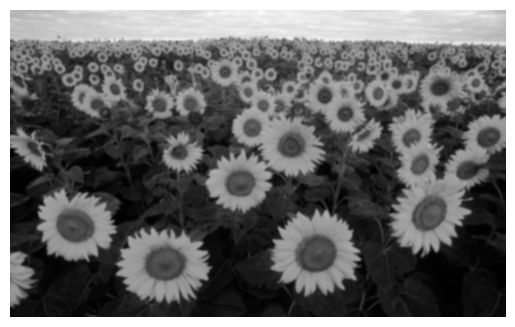

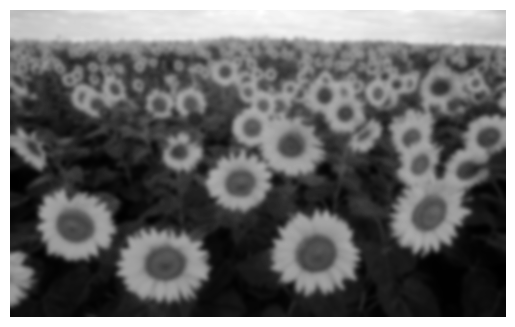

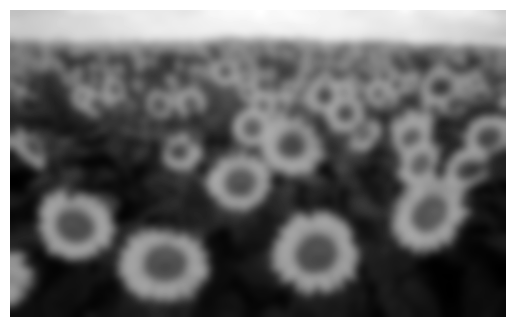

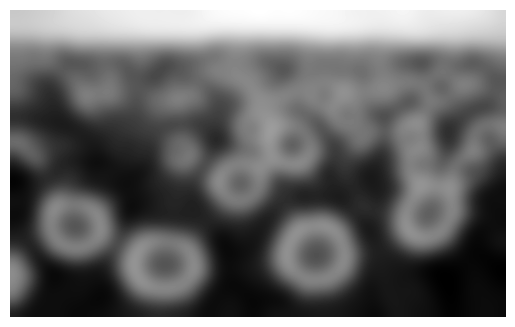

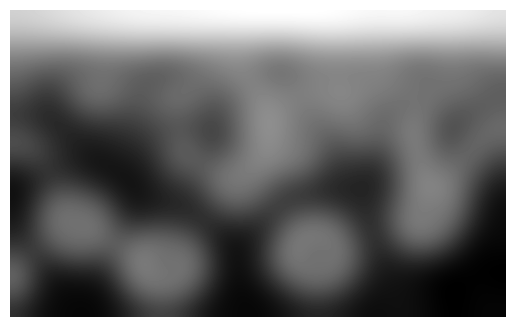

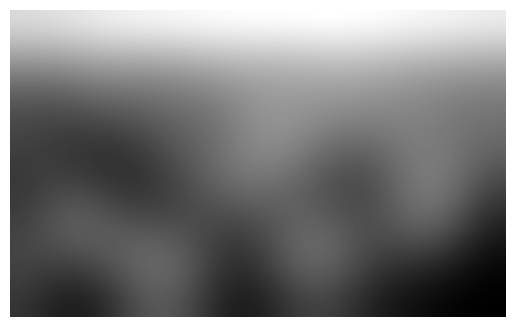

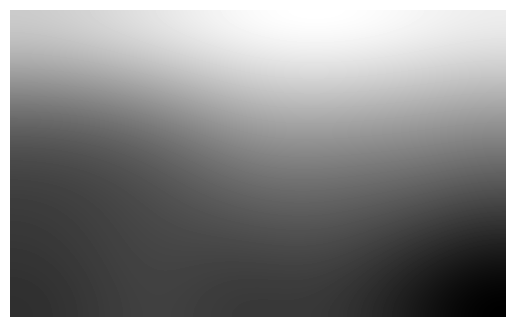

In [8]:
sigma = 2
n_scales = 7
im_scales, scales = scale_spaced(im, sigma, n_scales)

# Check images in pyramid are exactly the same as the original image
print(f"im shape: {im_scales[0].shape}")
print(f"scales: {scales}")
print(im_scales)

# Visualize images to check for progressive blur
for i, im_scale in enumerate(im_scales):
    plt.imshow(im_scale, cmap="gray")
    plt.axis("off")
    plt.show()
plt.show()

In [9]:
# Ex 8.2
def difference_of_gaussians(im, sigma, n):
    """
    Implementation of the difference of Gaussians.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales

    Returns:
        DoG : list of scale space DoGs of im
        scales : list containing the scales used in the pyramid
    """
    im_scales, scales = scale_spaced(im, sigma, n)
    DoG = []
    for i in range(1, n):
        diff = im_scales[i] - im_scales[i - 1]
        DoG.append(diff)
    return DoG, scales

In [10]:
sigma = 2
n_scales = 7
DoG, scales = difference_of_gaussians(im, sigma, n_scales)

# Check images in pyramid are exactly the same as the original image
print(f"No. of DoG images: {len(DoG)}")
print(f"im shape: {DoG[0].shape}")
print(DoG)

No. of DoG images: 6
im shape: (660, 1066)
[array([[ 0.0059075 ,  0.00596089,  0.00616792, ..., -0.00435692,
        -0.00338718, -0.00298916],
       [ 0.00402264,  0.00404804,  0.0041708 , ..., -0.00175515,
        -0.00092812, -0.00059838],
       [-0.00043291, -0.00050224, -0.00065489, ...,  0.00470136,
         0.00514083,  0.0052886 ],
       ...,
       [-0.00178919, -0.00089795,  0.00178506, ..., -0.00020731,
        -0.00061596, -0.00076987],
       [-0.00164213, -0.00063083,  0.00238786, ..., -0.00059324,
        -0.00106822, -0.00125629],
       [-0.00155511, -0.00049482,  0.00265691, ..., -0.00074288,
        -0.00123992, -0.00144001]]), array([[-0.0054719 , -0.00535346, -0.00499924, ...,  0.02464145,
         0.02477435,  0.0248203 ],
       [-0.0054965 , -0.00538033, -0.00503267, ...,  0.02458426,
         0.02471621,  0.02476186],
       [-0.00552652, -0.00541696, -0.00508847, ...,  0.02435891,
         0.02448853,  0.02453343],
       ...,
       [ 0.01133556,  0.011297

test shape2 (1174,)
test shape2 (197,)
test shape2 (84,)
test shape2 (41,)
test shape2 (11,)
test shape2 (0,)
(6, 660, 1066)


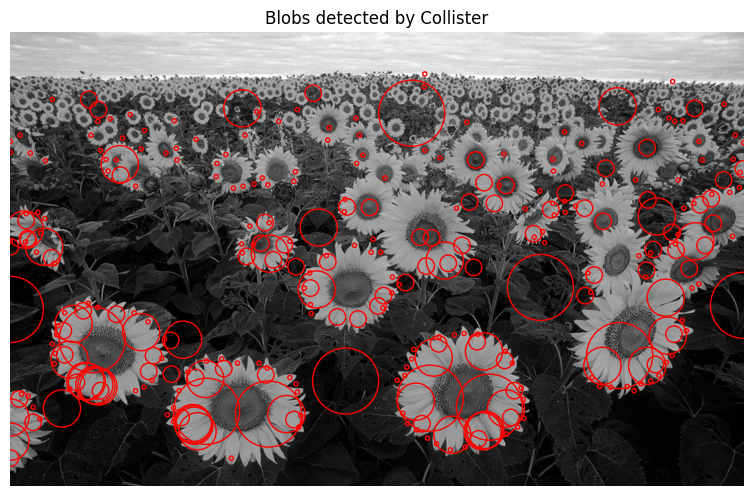

In [33]:
# From Collister's code
def detectBlobs(im, sigma, n, tau):
    DoG, scales = difference_of_gaussians(im, sigma, n)
    DoG = np.array(DoG)
    DoG = np.where(abs(DoG) >= tau, DoG, 0)
    results_list = []
    MaxDoG = [cv2.dilate(dog, np.ones((3, 3))) for dog in DoG]

    for index in range(DoG.shape[0]):
        DoG_current = DoG[index]
        index_above = index + 1
        index_below = index - 1

        DoG_current_MAX = cv2.dilate(abs(DoG_current), np.ones((3, 3)))
        try:
            DoG_above_MAX = MaxDoG[index_above]
        except IndexError:
            DoG_above_MAX = np.zeros(DoG.shape)
        try:
            DoG_below_MAX = MaxDoG[index_below]
        except IndexError:
            DoG_below_MAX = np.zeros(DoG.shape)

        x = np.nonzero(DoG_current)[0]
        y = np.nonzero(DoG_current)[1]
        test = np.zeros(DoG_current.shape)
        for a in range(len(x)):
            xi = x[a]
            yi = y[a]
            try:
                # check all surrounding 8 squares and top and bottom layers
                if (
                    abs(DoG_current[xi, yi]) == abs(DoG_current_MAX[xi, yi])
                    and abs(DoG_current[xi, yi]) > abs(DoG_above_MAX[xi, yi])
                    and abs(DoG_current[xi, yi]) > abs(DoG_below_MAX[xi, yi])
                ):
                    test[xi, yi] = 1
            except:
                continue  # there is some bug here but i have given up
        test_num = test[np.where(test > 0)]
        print("test shape2", test_num.shape)
        results_list.append(test)
    results_list = np.array(results_list)
    print(results_list.shape)
    return results_list


blobs = detectBlobs(im, 2, 7, 0.1)


im_circle = cv2.imread("media/sunflowers.jpg")
im_circle = cv2.cvtColor(im_circle, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(im, cmap="gray")
for i in range(len(blobs)):
    x = np.nonzero(blobs[i])[0]
    y = np.nonzero(blobs[i])[1]
    radius = 3 * (i**2)
    for a in range(len(x)):
        c = plt.Circle(
            (y[a], x[a]), radius, color="red", linewidth=1, fill=False
        )
        plt.gca().add_patch(c)
plt.tight_layout()
plt.axis("off")
plt.title("Blobs detected by Collister")
plt.show()

In [31]:
def visualize_blobs(blobs, im):
    """
    Args:
        blobs : list of detected blobs in the format (x, y, scale)
        im : BGR input image
    """
    gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # To draw colored shapes on a gray img
    bgr_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    for x, y, scale in blobs:
        cv2.circle(
            bgr_img, (y, x), radius=int(scale), color=(255, 0, 0), thickness=2
        )
    plt.axis("off")
    plt.imshow(bgr_img)
    plt.show()

No. of blobs detected in DoG 0: 1174
No. of blobs detected in DoG 1: 177
No. of blobs detected in DoG 2: 75
No. of blobs detected in DoG 3: 41
No. of blobs detected in DoG 4: 11
No. of blobs detected in DoG 5: 2
Total no. of blobs detected: 1480


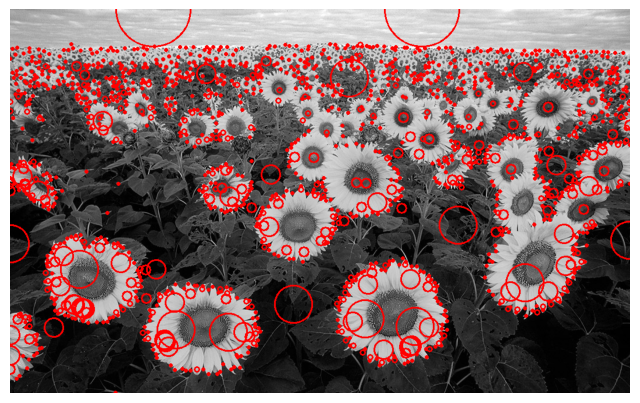

In [32]:
# Ex 8.3
def detect_blobs(im, sigma, n, tau):
    """
    Implementation of the blob detector.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales
        tau : threshold for blob detection

    Returns:
        blobs : list of detected blobs in the format (x, y, scale)
    """
    DoG, scales = difference_of_gaussians(im, sigma, n)
    DoG = np.array(DoG)

    # Obtain max value in a 3x3 neighborhood of each pixel in DoG
    MaxDoG = [cv2.dilate(abs(dog), np.ones((3, 3))) for dog in DoG]

    # Thresholding & non-max suppression
    blobs = []
    prev_blobs = 0
    for i in range(len(DoG)):  # for each DoG
        if i == 0:
            prev_MaxDoG = np.zeros(DoG[0].shape)
            next_MaxDoG = MaxDoG[i + 1]
        elif i == len(DoG) - 1:
            prev_MaxDoG = MaxDoG[i - 1]
            next_MaxDoG = np.zeros(DoG[0].shape)
        else:
            prev_MaxDoG = MaxDoG[i - 1]
            next_MaxDoG = MaxDoG[i + 1]

        for j in range(im.shape[0]):  # for each row
            for k in range(im.shape[1]):  # for each column
                # take abs() to find max and min
                if (
                    abs(DoG[i][j, k]) > tau  # thresholding
                    and abs(DoG[i][j, k])
                    == MaxDoG[i][j, k]  # max in current DoG
                    and abs(DoG[i][j, k])
                    > prev_MaxDoG[j, k]  # max in previous DoG
                    and abs(DoG[i][j, k]) > next_MaxDoG[j, k]  # max in next DoG
                ):
                    blobs.append((j, k, scales[i]))
        # Calculate how many new blobs detected in this DoG
        print(f"No. of blobs detected in DoG {i}: {len(blobs)-prev_blobs}")
        prev_blobs = len(blobs)
    return blobs


sigma = 2
n_scales = 7
tau = 0.1
blobs = detect_blobs(im, sigma, n_scales, tau)
print(f"Total no. of blobs detected: {len(blobs)}")
visualize_blobs(blobs, cv2.imread("media/sunflowers.jpg"))

## Using SIFT to match features

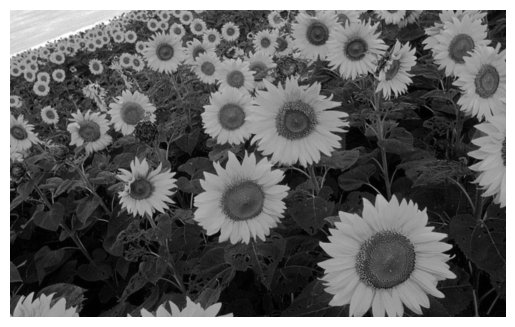

In [14]:
# Ex 8.4
def transform_im(im: np.ndarray, theta: float, s: float):
    """
    Rotate an image by theta degrees and scale by s.

    Args:
        im : input image
        theta : angle of rotation
        s : scaling factor

    Returns:
        r_im : rotated and scaled image
    """
    rows, cols = im.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), theta, s)
    r_im = cv2.warpAffine(im, M, (cols, rows))
    return r_im


r_im = transform_im(im, 20, 1.5)
plt.imshow(r_im, cmap="gray")
plt.axis("off")
plt.show()

In [17]:
# Ex 8.5
# Use SIFT detector to detect features in both original and transformed image.

# Read images as uint8
im_int = cv2.imread("media/sunflowers.jpg").mean(2).astype(np.uint8)
r_im_int = transform_im(im_int, 20, 1.5)

# SIFT detector
sift = cv2.SIFT_create()
kp1 = sift.detect(im_int, None)
kp2 = sift.detect(r_im_int, None)

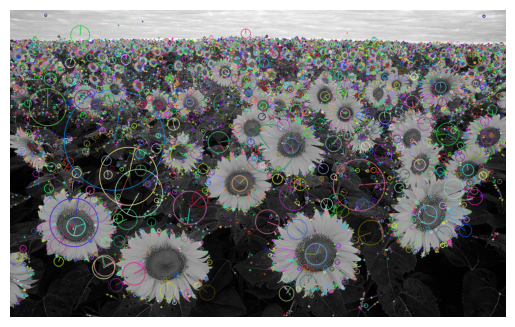

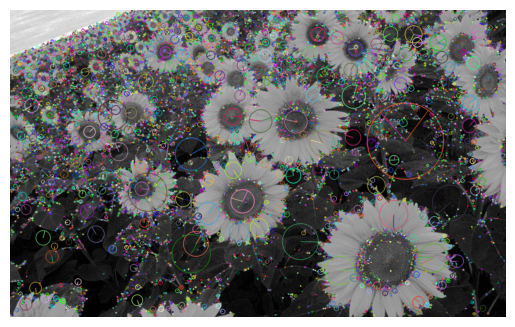

In [18]:
# Marking the keypoint on the image using circles
img = cv2.drawKeypoints(
    im_int, kp1, im_int, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

r_img = cv2.drawKeypoints(
    r_im_int, kp2, r_im_int, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# Plot features in both images.
plt.imshow(img)
plt.axis("off")
plt.show()
plt.imshow(r_img)
plt.axis("off")
plt.show()

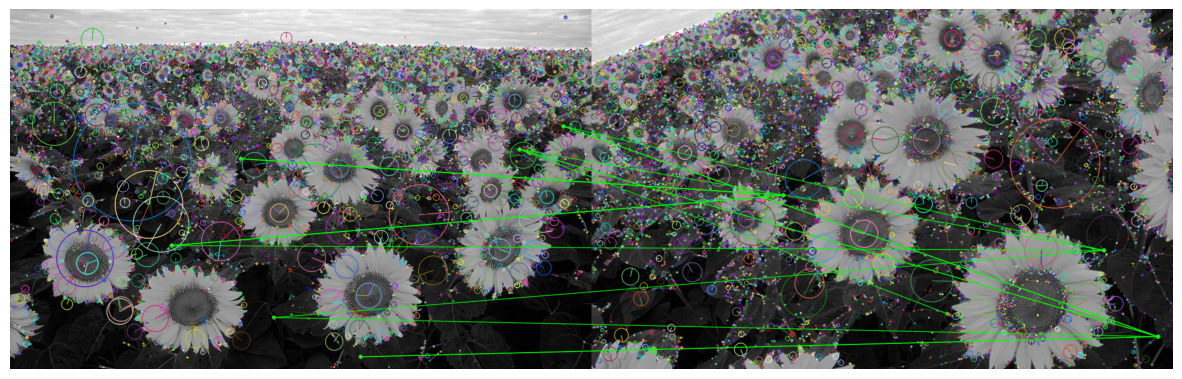

('good features',
 [[< cv2.DMatch 0000019CFDA911D0>],
  [< cv2.DMatch 0000019CFDA91290>],
  [< cv2.DMatch 0000019CFDA90FF0>],
  [< cv2.DMatch 0000019CFDA91610>],
  [< cv2.DMatch 0000019CFDA91270>],
  [< cv2.DMatch 0000019CFDA910D0>],
  [< cv2.DMatch 0000019CFDA92630>],
  [< cv2.DMatch 0000019CFDA90E10>],
  [< cv2.DMatch 0000019CFDA925B0>]])

In [19]:
def BFMatching(img1, img2, plot=False):
    """
    Modified from https://www.geeksforgeeks.org/python-opencv-bfmatcher-function/
    """
    # Find the keypoints and descriptors
    n_feats = 10
    sift = cv2.SIFT_create(n_feats)
    # sift = cv2.ORB_create(n_feats)
    kpnt1, des1 = sift.detectAndCompute(img1, None)
    kpnt2, des2 = sift.detectAndCompute(img2, None)

    # BFMatcher with default parameters
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    matched_image = cv2.drawMatchesKnn(
        img1,
        kpnt1,
        img2,
        kpnt2,
        matches,
        None,
        matchColor=(0, 255, 0),
        matchesMask=None,
        singlePointColor=(255, 0, 0),
        flags=0,
    )

    # Creating a criteria for the good matches
    for m, n in matches:
        if m.distance < 0.98 * n.distance:
            good.append([m])

    # Display matched image
    if plot:
        mpl.rcParams["figure.figsize"] = [15, 10]
        plt.imshow(matched_image)
        plt.axis("off")
        plt.show()
        mpl.rcParams["figure.figsize"] = [8, 6]

    return ("good features", good)  # returning ggod features


BFMatching(img, r_img, plot=True)
# This doesnt look correct